<a href="https://colab.research.google.com/github/walid-ame/FaceMaskDetection/blob/main/semi_supervised_face_mask_detection_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [41]:
import opendatasets as od
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import os
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
import numpy
from numpy import concatenate
from torch.utils.data import DataLoader

In [3]:
dataset_url = 'https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset'

In [4]:
od.download(dataset_url)

100%|██████████| 330M/330M [00:04<00:00, 75.9MB/s]


In [5]:
train_dir = '/content/face-mask-12k-images-dataset/Face Mask Dataset/Train'
valid_dir = '/content/face-mask-12k-images-dataset/Face Mask Dataset/Validation'
test_dir = '/content/face-mask-12k-images-dataset/Face Mask Dataset/Test'

In [6]:
os.listdir(train_dir)

['WithMask', 'WithoutMask']

In [9]:
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir + '/' + cls)))

WithMask : 5000
WithoutMask : 5000


In [10]:
for cls in os.listdir(valid_dir):
    print(cls, ':', len(os.listdir(valid_dir + '/' + cls)))

WithMask : 400
WithoutMask : 400


In [11]:
for cls in os.listdir(test_dir):
    print(cls, ':', len(os.listdir(test_dir + '/' + cls)))

WithMask : 483
WithoutMask : 509


In [13]:
train_ds = ImageFolder(train_dir)
valid_ds = ImageFolder(valid_dir)
test_ds= ImageFolder(test_dir)

train_ds.classes

['WithMask', 'WithoutMask']

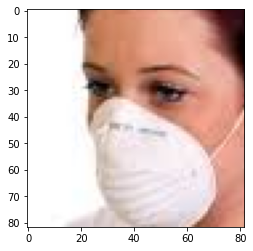

In [14]:
img, label = train_ds[102]
plt.imshow(img)

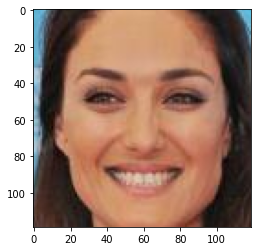

In [15]:
img, label = valid_ds[401]
plt.imshow(img)

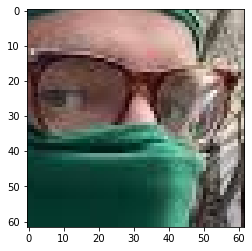

In [16]:
img, label = test_ds[50]
plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


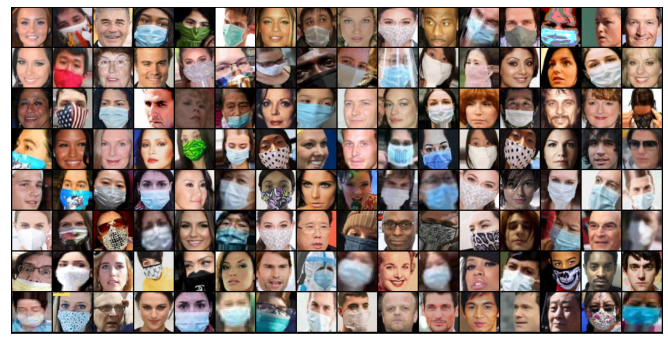

In [18]:
import torchvision.transforms as tt
train_ds = ImageFolder(train_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64 ),
                                             tt.ToTensor()]))

valid_ds = ImageFolder(valid_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64),
                                             tt.ToTensor()]))

test_ds = ImageFolder(test_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64),
                                             tt.ToTensor()]))



In [44]:
# define dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=1)

#x_train,y_train = train_dl
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)

X_test, y_test = make_classification(n_samples=800, n_features=2, n_informative=2, n_redundant=0, random_state=1)

# summarize training set size
print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
print('Unlabeled Train Set:', X_test_unlab.shape, y_test_unlab.shape)
# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (5000, 2) (5000,)
Unlabeled Train Set: (5000, 2) (5000,)
Test Set: (800, 2) (800,)


In [26]:
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]

In [27]:
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
len(X_train_mixed)
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

In [ ]:
#for cls in os.listdir(x_train_mixed_dir):
 #   print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

In [45]:
len(X_train_mixed) , len(y_train_mixed)

(10000, 10000)

In [46]:
# define model
model = LabelSpreading()
model

LabelSpreading()

fitting semi-supervised and score with real label

In [47]:

# fit model on training dataset
model.fit(X_train_mixed, y_train_mixed)
# make predictions on hold out test set
yhat = model.predict(X_test)
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 45.500


In [48]:
tran_labels = model.transduction_

GPU Utilities

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

torch.cuda.is_available()

False

In [35]:
device = get_default_device()
device

device(type='cpu')

In [49]:
train_dl = DeviceDataLoader(X_train_mixed, device)
valid_dl = DeviceDataLoader(valid_ds, device)


In [50]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Evaluates the model's performance on the validation set

In [51]:
@torch.no_grad()
def evaluate(model, val_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 this adaptive make it always 00*00*1*1 force the dimition to be 1*1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model resnet9 with more than 6 million parameters

In [40]:
model = to_device(ResNet9(3,2),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [58]:
batch_size = 128

x_train_dl = DataLoader(X_train_mixed, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
y_train_d1 = DataLoader(y_train_mixed,
                        batch_size,
                        num_workers = 4,
                        pin_memory = True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)



from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

In [61]:
torch.cuda.empty_cache()
for batch in (x_train_dl,y_train_lab):
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[{'val_acc': 0.5149739384651184, 'val_loss': 0.6930566430091858}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

AttributeError: ignored